In [58]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import root_mean_squared_error

In [59]:
df = pd.read_parquet('../data/final/2023_data.parquet')

In [60]:
categorical = ['date', 'dayofweek', 'away_league', 'home_league', 'park_id']
numerical = ['home_OPS_blend', 'home_FIP_blend', 'home_FPCT_blend', 'away_OPS_blend', 'away_FIP_blend', 'away_FPCT_blend']
target = ['home_won']

In [61]:
df_cat = df[categorical]
vec = DictVectorizer(sparse=False)
X_cat = vec.fit_transform(df_cat.to_dict(orient='records'))
cat_features = vec.get_feature_names_out()

In [62]:
df_num = df[numerical]
scaler = StandardScaler()
X_num = scaler.fit_transform(df_num)

In [63]:
X = np.hstack([X_num, X_cat])

In [64]:
y = df[target]

In [42]:
model = LogisticRegression()
model.fit(X, y)

/workspaces/saber-metrics-machine-learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [43]:
feature_names = list(numerical) + list(cat_features)

In [44]:
importance = pd.Series(abs(model.coef_[0]), index=feature_names)
importance = importance.sort_values(ascending=False)
print(importance)

date               4.152108e-09
home_OPS_blend     1.162680e-15
away_OPS_blend     1.118324e-15
home_FIP_blend     6.897574e-16
away_FIP_blend     6.882551e-16
home_FPCT_blend    4.534837e-16
home_league=NL     3.321833e-16
dayofweek=Sun      2.219896e-16
park_id=OAK01      1.888921e-16
dayofweek=Fri      1.861030e-16
park_id=STP01      1.373303e-16
park_id=LOS03      1.373302e-16
park_id=CHI12      1.284806e-16
home_league=AL     1.269445e-16
away_league=NL     1.267840e-16
park_id=ATL03      1.252479e-16
park_id=KAN06      1.043160e-16
park_id=ARL03      1.010833e-16
park_id=WAS11      9.810568e-17
park_id=BAL12      8.900100e-17
park_id=MIL06      8.900100e-17
park_id=PHI13      8.900099e-17
park_id=STL10      7.981310e-17
away_league=AL     7.845479e-17
dayofweek=Sat      7.531071e-17
dayofweek=Wed      7.066964e-17
away_FPCT_blend    7.054945e-17
park_id=MIN04      6.483639e-17
park_id=DET05      5.598672e-17
park_id=DEN02      5.598672e-17
park_id=MIA02      5.275408e-17
dayofwee

In [45]:
importance[importance > 0.001]

Series([], dtype: float64)

In [46]:
from sklearn.metrics import roc_auc_score
y_prob = model.predict_proba(X)[:, 1]
auc = roc_auc_score(y, y_prob)

In [47]:
auc

0.4977674087827017

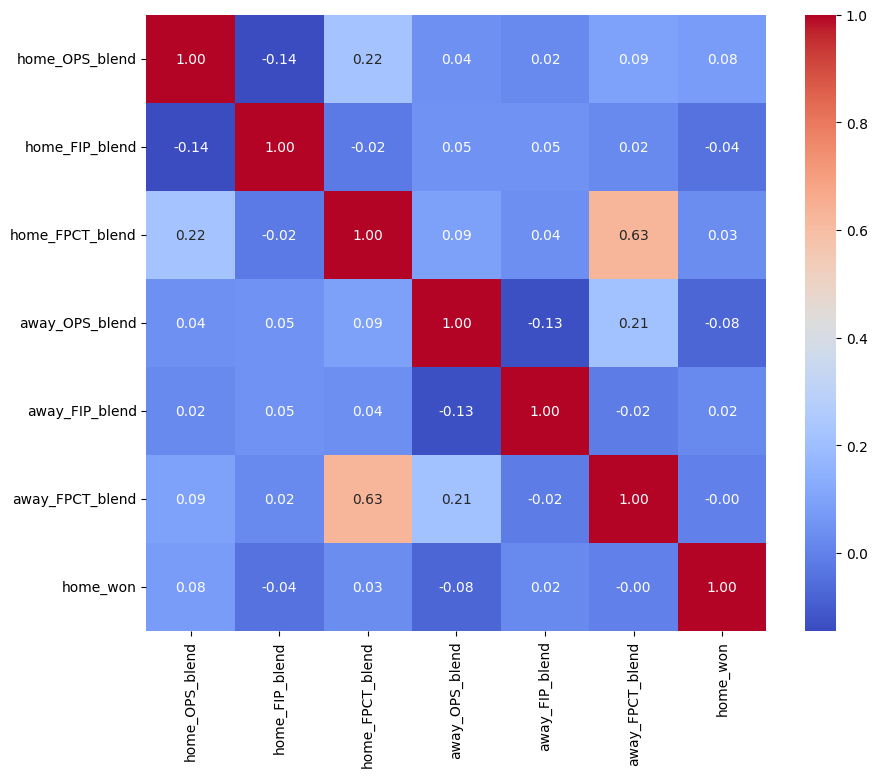

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[numerical+target].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [66]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [67]:
vec = DictVectorizer(sparse=False)
X_train = vec.fit_transform(df[categorical+numerical].to_dict(orient='records'))
all_features = vec.get_feature_names_out()

In [68]:
y_train = df[target]

In [69]:
rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        random_state=42,
        n_jobs=-1)

In [70]:
rf.fit(X_train, y_train)

/workspaces/saber-metrics-machine-learning/.venv/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,200
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [71]:
importances = rf.feature_importances_

In [72]:
y_pred = rf.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
auc

0.7482078196337736

In [73]:
feat_imp = pd.DataFrame({'feature': all_features, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False)

In [57]:
feat_imp.head(10)

,feature,importance
15,home_OPS_blend,0.130091
2,away_OPS_blend,0.121298
14,home_FPCT_blend,0.109243
0,away_FIP_blend,0.104327
13,home_FIP_blend,0.094777
1,away_FPCT_blend,0.089452
5,date,0.069348
39,park_id=OAK01,0.033644
6,dayofweek=Fri,0.016461
9,dayofweek=Sun,0.015235


In [32]:
len(feat_imp)

51

In [30]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

In [31]:
scale_pos_weight

1.0